In [2]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.impute import SimpleImputer
import supplemental_english as supplement

**Dataset Description**

- A training dataset (train.csv) of known offers with plate numbers, dates, and prices.
- A test dataset (test.csv) with other plate numbers and dates, for which you must predict the price.
- A sample submission file (sample_submission.csv) showing the required submission format.
- Additionally we have two supplemental materials:
  -  REGION_CODES: A dictionary mapping region names in Russia to their official numeric codes (e.g., "77" for the city of Moscow, "78" for the city of "Saint-Petersburg", and so forth).
  -  A dictionary listing special (often privileged) government-affiliated plates, which may affect pricing or vehicle status in some way.

**Goal**

Predict the price in the test dataset as accurately as possible (SMAPE metric).

**What part of number plate mean**
![Car Plate Format](https://cdn.skoda-storyboard.com/2019/04/Russian-license-plate-english.jpg)

# Reading the data

In [3]:
train = pd.read_csv('/kaggle/input/russian-car-plates-prices-prediction/train.csv')
test = pd.read_csv('/kaggle/input/russian-car-plates-prices-prediction/test.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51635 entries, 0 to 51634
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      51635 non-null  int64 
 1   plate   51635 non-null  object
 2   date    51635 non-null  object
 3   price   51635 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.6+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7695 entries, 0 to 7694
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      7695 non-null   int64  
 1   plate   7695 non-null   object 
 2   date    7695 non-null   object 
 3   price   0 non-null      float64
dtypes: float64(1), int64(1), object(2)
memory usage: 240.6+ KB


# Supplementary functions to extract features

In [6]:
# support functions to extract features from number plate
def parse_plate_info(df, plate_col, significance_dict):
    '''
        This function is used to extract additional features from numberplate
        using supplementary data that was given to us.
        This data extracts additional features like:
        If number plate is forbidden to buy,
        Has advantage on road
        significance level based on dataset's author's understanding
        Category of drive (like government official, institutions, etc.)
    '''
    def extract_features(plate):
        match = re.match(r'^([A-Z]{1,3})(\d{3})([A-Z]{1,2})(\d{2,3})$', plate)
        if not match:
            return pd.Series([None] * 7, 
                             index=['series_letters', 'number_range', 'region_code',
                                    'is_forbidden_to_buy', 'has_advantage_on_road', 
                                    'significance_level', 'owner_category'])

        prefix_letter1, num_str, prefix_letter2, region = match.groups()
        series_letters = prefix_letter1 + prefix_letter2
        number_range = int(num_str)
        region_code = region

        # Search in the dictionary
        for (letters, num_range, reg_code), (owner, forbidden, advantage, level) in significance_dict.items():
            if series_letters == letters and num_range[0] <= number_range <= num_range[1] and region_code == reg_code:
                return pd.Series([series_letters, number_range, region_code, 
                                  forbidden, advantage, level, owner],
                                 index=['series_letters', 'number_range', 'region_code',
                                        'is_forbidden_to_buy', 'has_advantage_on_road', 
                                        'significance_level', 'owner_category'])

        # If no match found
        return pd.Series([series_letters, number_range, region_code, 
                          0, 0, 0, 'Unknown'],
                         index=['series_letters', 'number_range', 'region_code',
                                'is_forbidden_to_buy', 'has_advantage_on_road', 
                                'significance_level', 'owner_category'])

    # Apply extraction to the dataframe
    extracted_df = df[plate_col].apply(extract_features)
    return pd.concat([df, extracted_df], axis=1)

def extract_plate_features(df):
    '''
        This feature simply extract visible features like day, month, year, repeated digits, etc.
    '''
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    
    # Extract plate components
    # df['prefix'] = df['plate'].str.extract(r'^([A-ZА-Я]{1,3})')[0]
    # df['number'] = df['plate'].str.extract(r'(\d{3})')[0].astype(int)
    # df['region_code'] = df['plate'].str.extract(r'(\d{2,3})$')[0].astype(int)
    
    # Date features
    df['year'] = df['date'].dt.year
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    df['day_of_year'] = df['date'].dt.dayofyear
    
    # Special plate indicators
    df= parse_plate_info(df, 'plate', supplement.GOVERNMENT_CODES)
    df['is_000'] = (df['number_range'] == 0).astype(int)
    df['is_repdigit'] = (df['number_range'].astype(str).str[0] == df['number_range'].astype(str).str[1]) & \
                       (df['number_range'].astype(str).str[1] == df['number_range'].astype(str).str[2]).astype(int)
    
    # Popular regions (Moscow, St. Petersburg)
    df['is_moscow'] = (df['region_code'] == '77').astype(int)
    df['is_spb'] = (df['region_code'] == '78').astype(int)
    
    return df

Let's extract features as there no null values in both train & test

In [7]:
train = extract_plate_features(train)
test = extract_plate_features(test)

In [8]:
train.head()

,id,plate,date,price,year,day,weekday,day_of_year,series_letters,number_range,region_code,is_forbidden_to_buy,has_advantage_on_road,significance_level,owner_category,is_000,is_repdigit,is_moscow,is_spb
0,1,X059CP797,2024-12-26 00:00:00,65000,2024,26,3,361,XCP,59,797,0,0,0,Unknown,0,False,0,0
1,2,Y800MH790,2024-07-12 21:31:37,100000,2024,12,4,194,YMH,800,790,0,0,0,Unknown,0,False,0,0
2,3,A212TX77,2024-04-18 00:00:00,290000,2024,18,3,109,ATX,212,77,0,0,0,Unknown,0,False,1,0
3,4,P001AY199,2025-01-03 00:27:15,680000,2025,3,4,3,PAY,1,199,0,0,0,Unknown,0,False,0,0
4,5,P001AY199,2025-01-10 09:32:41,750000,2025,10,4,10,PAY,1,199,0,0,0,Unknown,0,False,0,0


In [9]:
test.head()

,id,plate,date,price,year,day,weekday,day_of_year,series_letters,number_range,region_code,is_forbidden_to_buy,has_advantage_on_road,significance_level,owner_category,is_000,is_repdigit,is_moscow,is_spb
0,51636,P700TT790,2025-01-27,NaN,2025,27,0,27,PTT,700,790,0,0,0,Unknown,0,False,0,0
1,51637,M081TX797,2025-02-10,NaN,2025,10,0,41,MTX,81,797,0,0,0,Unknown,0,False,0,0
2,51638,T333HX777,2025-02-11,NaN,2025,11,1,42,THX,333,777,0,0,0,Unknown,0,True,0,0
3,51639,H744BH977,2025-02-03,NaN,2025,3,0,34,HBH,744,977,0,0,0,Unknown,0,False,0,0
4,51640,X066EM777,2025-02-12,NaN,2025,12,2,43,XEM,66,777,0,0,0,Unknown,0,False,0,0


In [10]:
X = train.drop(['id', 'plate', 'date', 'price'], axis=1)
y = train['price']
X_test = test.drop(['id', 'plate', 'date', 'price'], axis=1)

In [13]:
categorical_features = ['series_letters','is_000', 'owner_category']
numerical_features = [col for col in X.columns if col not in categorical_features]

Let's check multicolinearity & correlation using heatmap for numeric features

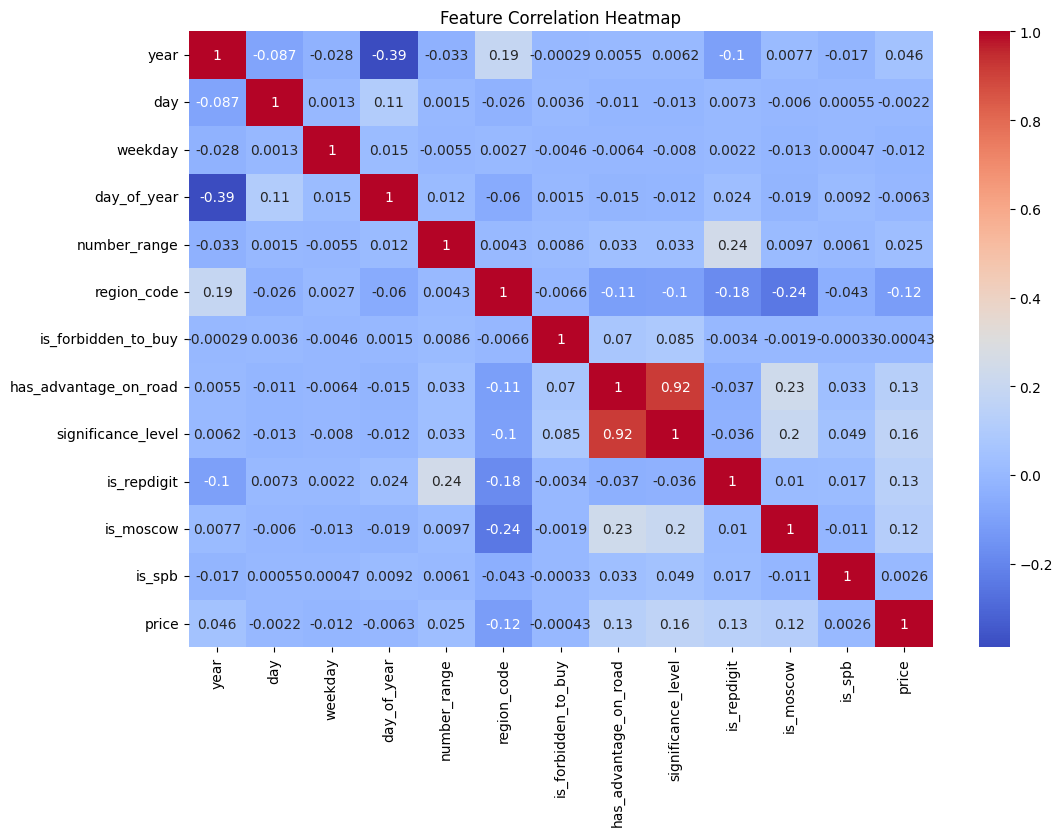

In [14]:
plt.figure(figsize=(12, 8))
sns.heatmap(train[numerical_features + ['price']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

- As we can see from the heatmap has_advantage_on_road & significance_level are colinear, hence I will only choose signigicance level & drop has_advantage_on_road.
- We will also remove 'owner category' as there are many categories & details are mostly captured in significance level.

In [15]:
# Define SMAPE scoring (competition metric)
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

smape_scorer = make_scorer(smape, greater_is_better=False)

In [16]:
X = X.drop(['has_advantage_on_road', 'owner_category'], axis=1)
X_test = X_test.drop(['has_advantage_on_road', 'owner_category'], axis=1)

# updating categorical & numerical features
categorical_features = ['series_letters','is_000']
numerical_features = [col for col in X.columns if col not in categorical_features]

In [17]:
X.head()

,year,day,weekday,day_of_year,series_letters,number_range,region_code,is_forbidden_to_buy,significance_level,is_000,is_repdigit,is_moscow,is_spb
0,2024,26,3,361,XCP,59,797,0,0,0,False,0,0
1,2024,12,4,194,YMH,800,790,0,0,0,False,0,0
2,2024,18,3,109,ATX,212,77,0,0,0,False,1,0
3,2025,3,4,3,PAY,1,199,0,0,0,False,0,0
4,2025,10,4,10,PAY,1,199,0,0,0,False,0,0


In [18]:
# defining preprocessor for pipeline
preprocessor = ColumnTransformer([
    ('imputer', SimpleImputer(), numerical_features),
    ('ohe', OneHotEncoder(), categorical_features)
])

#defining list of models for pipeline
model = GradientBoostingRegressor(random_state=42)
model2 = RandomForestRegressor(random_state=42)
model3 = Lasso(random_state=42)

# building a pipeline
pipe1 = Pipeline(
    [('preprocessor', preprocessor),
    ('model', model)]
)

pipe2 = Pipeline(
    [('preprocessor', preprocessor),
    ('model', model2)]
)

pipe3 = Pipeline(
    [('preprocessor', preprocessor),
    ('model', model3)]
)

In [19]:
pipe1.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('imputer', SimpleImputer(),
                                                  ['year', 'day', 'weekday',
                                                   'day_of_year',
                                                   'number_range',
                                                   'region_code',
                                                   'is_forbidden_to_buy',
                                                   'significance_level',
                                                   'is_repdigit', 'is_moscow',
                                                   'is_spb']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['series_letters',
                                                   'is_000'])])),
                ('model', GradientBoostingRegressor(random_state=42))])

In [20]:
results={}

cv_scores = cross_val_score(pipe1, X, y, cv=5, scoring=smape_scorer)
results = -cv_scores.mean()  # Convert back to positive SMAPE
    
print(f" Gradient_boosting: Mean SMAPE = {-cv_scores.mean():.2f} (±{cv_scores.std():.2f})")

 Gradient_boosting: Mean SMAPE = 70.65 (±0.87)


In [22]:
pipe2.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('imputer', SimpleImputer(),
                                                  ['year', 'day', 'weekday',
                                                   'day_of_year',
                                                   'number_range',
                                                   'region_code',
                                                   'is_forbidden_to_buy',
                                                   'significance_level',
                                                   'is_repdigit', 'is_moscow',
                                                   'is_spb']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['series_letters',
                                                   'is_000'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [23]:
results={}

cv_scores = cross_val_score(pipe2, X, y, cv=5, scoring=smape_scorer)
results = -cv_scores.mean()  # Convert back to positive SMAPE

print(f" Random Forest Regressor: Mean SMAPE = {-cv_scores.mean():.2f} (±{cv_scores.std():.2f})")

 Random Forest Regressor: Mean SMAPE = 47.21 (±0.33)


In [24]:
pipe3.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('imputer', SimpleImputer(),
                                                  ['year', 'day', 'weekday',
                                                   'day_of_year',
                                                   'number_range',
                                                   'region_code',
                                                   'is_forbidden_to_buy',
                                                   'significance_level',
                                                   'is_repdigit', 'is_moscow',
                                                   'is_spb']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['series_letters',
                                                   'is_000'])])),
                ('model', Lasso(random_state=42))])

In [25]:
results={}

cv_scores = cross_val_score(pipe3, X, y, cv=5, scoring=smape_scorer)
results = -cv_scores.mean()  # Convert back to positive SMAPE
print(f" Lasso: Mean SMAPE = {-cv_scores.mean():.2f} (±{cv_scores.std():.2f})")

 Lasso: Mean SMAPE = 107.13 (±1.30)


Since SMAPE is lowest for Gradient Boosting we will select that model & perform hyperparameter tuning.

In [26]:
# Let's tune the best performing model (Random Forest in this case)
param_grid = {
    #'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(pipe2, param_grid, cv=5, scoring=smape_scorer, n_jobs=-1)
grid_search.fit(X, y)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best SMAPE score: {-grid_search.best_score_:.2f}")

Best parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Best SMAPE score: 47.21


In [27]:
best_model = grid_search.best_estimator_

In [28]:
# fetching feature names including encoded categorical features
feature_names = numerical_features.copy()
for col in categorical_features:
    categories = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].categories_[categorical_features.index(col)]
    feature_names.extend([f"{col}_{cat}" for cat in categories])

KeyError: 'cat'

In [32]:
best_model.preprocessor

AttributeError: 'Pipeline' object has no attribute 'preprocessor'